In [75]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

sns.set_style("darkgrid")
sns.set_palette("hls", 8)

In [8]:
hotel_info_path = '../web-scraping/d1fe8412-b9cb-46b9-ab5b-b5116e3fa965_The Social Hub Groningen_17-12-2023_19-11.json'

with open(hotel_info_path, 'r') as f:
    hotel_info_data = json.load(f)

hotel_info_data

{'hotel_name': 'The Social Hub Groningen',
 'hotel_link': 'https://www.booking.com/hotel/nl/the-social-hub-groningen.en.html',
 'address': 'Boterdiep 9, 9712 LH Groningen, Netherlands',
 'scraping_date': '17-12-2023_19-11',
 'nr_reviews': 3298,
 'overall_score': 8.3}

# Dataset
    - review_title (string) = the title of the review
    - review_date (string) = the date when the review was posted
    - reviewer_country (string) - the country of the reviewer
    - room_type (string) = the type of room as defined by each hotel (example: Deluxe King Room)
    - party_size (string) = the type of group traveling (example: couple, family)
    - nr_nights (int) = the number of nights stayed in the hotel
    - date_stay (string) = the starting date of the stay in the hotel
    - review_score (float) = the score given by the reviewer
    - review_great (string) = the text of the positive review. If missing, then N/A.
    - review_poor (string) = The text of the negative review. If missing, then N/A.
    - hotel_response_bool (bool) = Whether or not the hotel has responded to the review.

In [13]:
hotel_reviews_path = '../web-scraping/d1fe8412-b9cb-46b9-ab5b-b5116e3fa965_The Social Hub Groningen_17-12-2023_19-11.csv'

hotel_reviews_data = pd.read_csv(hotel_reviews_path)
hotel_reviews_data.head()

,review_title,review_date,reviewer_country,room_type,party_size,nr_nights,date_stay,review_score,review_great,review_poor,hotel_response_bool
0,Exceptional,08-2022,Turkey,Deluxe King Room,Solo traveller,1,08-2022,10.0,Everything was perfect. + shower gel and soap ...,NaN,False
1,"Great place, great staff, great breakfast",12-2023,United States,Deluxe King Room,Solo traveller,3,12-2023,8.0,"Good vibe, young, modern, easy",NaN,True
2,Good place to stay.,11-2023,United States,Deluxe King Room,Couple,3,11-2023,8.0,The hotel was nice and had good amenities. Sta...,The arrangements for the laundry were challeng...,True
3,Good,08-2023,Germany,Standard Queen Room,Couple,6,08-2023,7.0,Very friendly staff and good location.,Very simple and not completely cleaned room.,True
4,I would come back :),10-2023,Germany,Standard Queen Room,Solo traveller,1,10-2023,8.0,"The location is great, good atmosphere with ma...","Staff was friendly, but not always where I exp...",True


In [20]:
num_entries = hotel_reviews_data.shape[0]
print("Total number of entries:", num_entries)

num_entries_review_poor_notna = hotel_reviews_data['review_poor'].notna().sum()
print("Number of negative reviews:", num_entries_review_poor_notna)

num_entries_review_poor_notna = hotel_reviews_data['review_great'].notna().sum()
print("Number of positive reviews:", num_entries_review_poor_notna)

num_entries_review_poor_or_great_notna = hotel_reviews_data[['review_poor', 'review_great']].notna().any(axis=1).sum()
print("Number of entries with at least one type of review:", num_entries_review_poor_or_great_notna)

mean_review_score = hotel_reviews_data['review_score'].mean()
print("Mean review_score for all entries:", mean_review_score)


Total number of entries: 3310
Number of negative reviews: 1178
Number of positive reviews: 1477
Number of entries with at least one type of review: 1528
Mean review_score for all entries: 8.329818731117825


# Review score over time

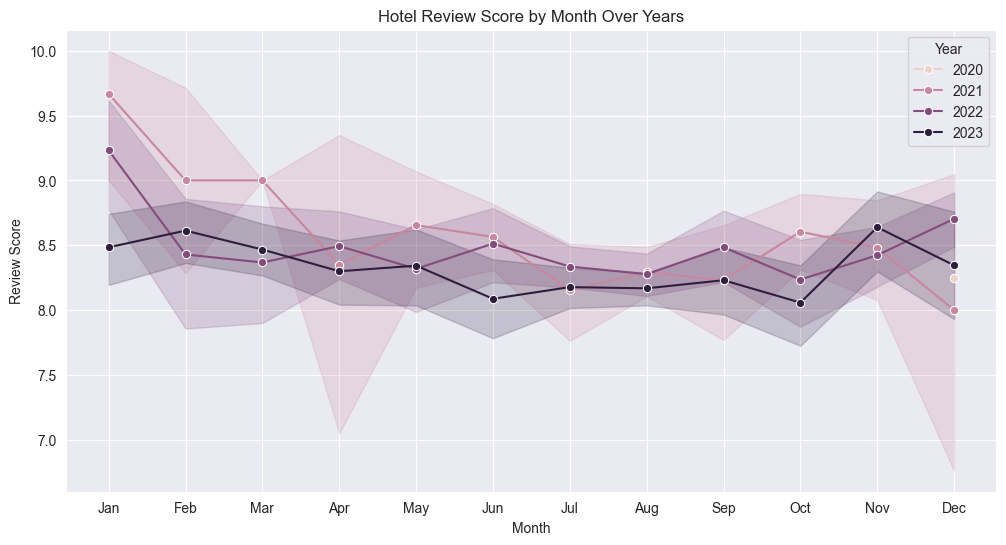

In [73]:
hotel_reviews_data['review_date'] = pd.to_datetime(hotel_reviews_data['review_date'], format='%m-%Y')

# Extract month, year, and season
hotel_reviews_data['month'] = hotel_reviews_data['review_date'].dt.month
hotel_reviews_data['year'] = hotel_reviews_data['review_date'].dt.year
hotel_reviews_data['season'] = hotel_reviews_data['review_date'].dt.month % 12 // 3 + 1

# Map season numbers to season names
seasons = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
hotel_reviews_data['season'] = hotel_reviews_data['season'].map(seasons)

plt.figure(figsize=(12, 6))
sns.lineplot(data=hotel_reviews_data, x='month', y='review_score', hue='year', marker='o')
plt.title('Hotel Review Score by Month Over Years')
plt.xlabel('Month')
plt.ylabel('Review Score')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.grid(True)
plt.show()

# Review score per country

                  Counts  Mean Review Score
reviewer_country                           
India                  4           8.500000
Netherlands         1538           8.256892
Romania               61           9.114754
United Kingdom        49           8.530612


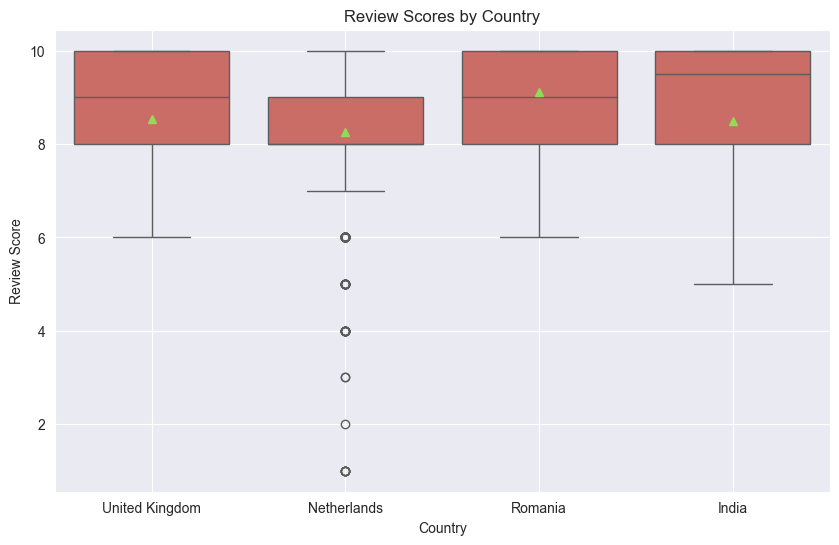

In [76]:
selected_countries = ['Netherlands', 'Romania', 'United Kingdom', 'India']  # Replace with the countries you want to show
filtered_data = hotel_reviews_data[hotel_reviews_data['reviewer_country'].isin(selected_countries)]

country_counts = filtered_data['reviewer_country'].value_counts()
country_mean_score = filtered_data.groupby('reviewer_country')['review_score'].mean()

country_table = pd.DataFrame({'Counts': country_counts, 'Mean Review Score': country_mean_score})
print(country_table)

plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_data, x='reviewer_country', y='review_score', showmeans=True)
plt.title('Review Scores by Country')
plt.xlabel('Country')
plt.ylabel('Review Score')
plt.grid(True)
plt.show()

# Review score per room type

                     Counts  Mean Review Score
room_type                                     
Deluxe King Room       1222           8.475450
Deluxe Queen Room         2           8.000000
Deluxe Studio            78           7.346154
Standard Queen Room    1917           8.281899


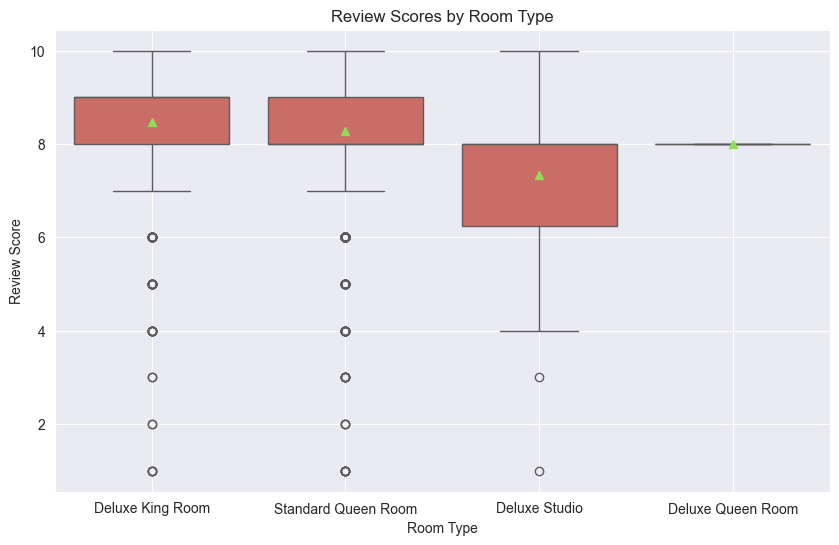

In [77]:
room_type_counts = hotel_reviews_data['room_type'].value_counts()
room_type_mean_score = hotel_reviews_data.groupby('room_type')['review_score'].mean()

room_type_table = pd.DataFrame({'Counts': room_type_counts, 'Mean Review Score': room_type_mean_score})
print(room_type_table)

plt.figure(figsize=(10, 6))
sns.boxplot(data=hotel_reviews_data, x='room_type', y='review_score', showmeans=True)
plt.title('Review Scores by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Review Score')
plt.grid(True)
plt.show()
